In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy import stats, special
from numpy import random
from collections import namedtuple, Counter

np.set_printoptions(precision=2)

In [2]:
def generate(weights, means, var, N):
    """Generate data from a mixture model with fixed mean variance
    """
    samples = []
    components = []
    assert(len(weights) == len(means))
    assert(sum(weights) == 1)
    for i in range(N):
        component = random.choice(range(len(means)), p=weights)
        samples.append(random.normal(means[component], np.sqrt(var)))
        components.append(component)
    return np.array(samples), np.array(components)


def group_data(X, c):
    return {cluster: 
            [x for x, assignment in zip(X, c) 
             if assignment == cluster] 
            for cluster in set(c)}


def shuffle(state):
    z = list(zip(state['data'], state['c']))
    random.shuffle(z)
    state['data'], state['c'] = map(list, zip(*z))
    return state


def state_score(state):
    """Total likelihood of state
    """
    cluster_labels = state['suffstats'].keys()
    a = np.array([suffstat_score(cluster, state) 
                  for cluster in cluster_labels])

    b = np.array([cluster_assign_score(cluster, state) 
                  for cluster in cluster_labels])
    return (a + b).sum()

In [3]:
SuffStat = namedtuple('SuffStat', 'N mu count_times_variance')

def generate_suffstat(X):
    X = np.array(X)
    N = len(X)
    count_times_variance = np.var(X) * N
    return SuffStat(N, X.mean(), count_times_variance)

## Update
# def add_datapoint_to_suffstats(x, ss):
#     """Update sufficient stats for normal component with new datapoint
#     """
#     N = ss.N + 1
#     mu = (ss.mu * (N - 1) + x) / N
#     return SuffStat(N, mu)

## Update
# def remove_datapoint_from_suffstats(x, ss):
#     """Remove datapoint from sufficient stats for normal component
#     """
#     N = ss.N - 1
#     mu = (ss.mu * (N + 1) - x * 1.0) / N
#     return SuffStat(N, mu)

def suffstat_score(cluster, state):
#     """https://github.com/forcedotcom/distributions/blob/8d4d8eebbcec14fa9f4c314425f127e1316d9951/distributions/dbg/models/nich.py#L180-L189
#     """
    pass

    

def cluster_assign_score(cluster, state):
    """From Algorithm 24.1 in Murphy 2012
    
    What is the probability of the datapoint being in cluster?
    """
    current_cluster_size, num_clusters, alpha = state['suffstats'][cluster].N, state['K'], state['alpha']
    return np.log(current_cluster_size - 1 + alpha * 1. / num_clusters)


def get_posterior_params_nich(cluster, state):
    """
    \cite{murphy2007conjugate}, Eqs.141-144
    """
    count, mean, count_times_variance = state["suffstats"][cluster]
    mu0, sigmasq0, kappa0, nu0 = state['mu_0'], state['sigmasq_0'], state['kappa_0'], state['nu_0']

    total = mean * count
    mu_1 = mu0 - mean
    kappa_n = kappa0 + count
    mu_n = (kappa0 * mu0 + total) / kappa_n
    nu_n = nu0 + count
    sigmasq_n = 1. / nu_n * (
        nu0 * sigmasq0
        + count_times_variance
        + (count * kappa0 * mu_1 * mu_1) / kappa_n)
    return mu_n, sigmasq_n, kappa_n, nu_n 


def posterior_predictive_score(x, cluster, state):
    
    mu, sigmasq, kappa, nu = get_posterior_params_nich(cluster, state)
    t_score = score_student_t(
        x,
        nu=nu,
        mu=mu,
        sigmasq=((1. + kappa) * sigmasq) / kappa)

    return t_score


def score_student_t(x, nu, mu, sigmasq):
    """
    \cite{murphy2007conjugate}, Eq. 304
    """
    score = special.gammaln(.5 * (nu + 1.)) - special.gammaln(.5 * nu)
    score -= .5 * np.log(nu * np.pi * sigmasq)
    xt = (x - mu)
    s = xt * xt / sigmasq
    score += -(.5 * (nu + 1.)) * np.log(1. + s / nu)
    return score


## Update
# def sample_marginalized_parameters(state):
#     alpha = state['alpha']
#     num_clusters = state["K"]
#     mu_0, sigmasq_0, param_var = state['mu_0'], state['sigmasq_0'], state['param_var']
#     pi = stats.dirichlet([ss.N + alpha * 1.0 / num_clusters for ss in state["suffstats"].values()]).rvs()[0]
#     mus = []
#     for cluster, ss in state["suffstats"].iteritems():
#         numerator = (mu_0 / sigmasq_0 + 
#                      ss.mu * ss.N / param_var)
#         denominator = (1.0 / sigmasq_0 + ss.N / param_var)
#         posterior_mu = numerator / denominator
#         posterior_sigma2 = 1.0 / (1.0 / sigmasq_0 + ss.N)
#         mus.append(stats.norm(posterior_mu, np.sqrt(posterior_sigma2)).rvs())
#     return pi, np.array(mus)

In [4]:
def gibbs_step(state, infer_mu0=True):
    state = shuffle(state)
    K = len(state['suffstats'])
    for i, (datapoint, cluster) in enumerate(zip(state['data'], state['c'])):

        #  state['suffstats'][cluster] = remove_datapoint_from_suffstats(datapoint, 
        #                                                                state['suffstats'][cluster])
        pts = [x for index, x in enumerate(state['data']) if state["c"][index] == cluster and i != index]
        state['suffstats'][cluster] = generate_suffstat(pts)

        cluster_labels = state['suffstats'].keys()
        t = [posterior_predictive_score(0, cluster, state)
                             for cluster in cluster_labels]
        predictive_scores = [posterior_predictive_score(datapoint, cluster, state)
                             for cluster in cluster_labels]
        cluster_scores = [cluster_assign_score(cluster, state)
                          for cluster in cluster_labels]
        scores = np.array(predictive_scores) + np.array(cluster_scores)
        scores = np.exp(scores) / np.exp(scores).sum()
        new_cluster = random.choice(cluster_labels, p=scores)
        state['c'][i] = new_cluster
        # state['suffstats'][new_cluster] = add_datapoint_to_suffstats(datapoint, state['suffstats'][new_cluster])
        pts = [x for index, x in enumerate(state['data']) if state['c'][index] == new_cluster]
        state['suffstats'][new_cluster] = generate_suffstat(pts)
        
#     if infer_mu0:
#         current_prior_mu = state['mu_0']
#         current_score = state_score(state)
#         state['mu_0'] = current_prior_mu + random.normal(scale=.1)
#         proposal_score = state_score(state)
#         diff = min(proposal_score - current_score, 0)
#         if np.log(stats.uniform(0, 1).rvs()) < diff:
#             pass
#         else:
#             state['mu_0'] = current_prior_mu
    return state

In [5]:
def initial_state(N=200):
    state = {'data' : None, 
             'c' : None, 
             'suffstats' : None, 
             'mu_0' : 0., 
             'sigmasq_0' : 1., 
             'kappa_0': 1.,
             'nu_0': 1.,
             'alpha': 1}
    ground_truth_weights, ground_truth_means = [.4, .6], [-1, 1]
    state["K"] = len(ground_truth_means)
    state['data'], ground_truth_c = generate(ground_truth_weights, ground_truth_means, .5, N)
    state['c'] = [random.choice(range(state["K"])) for _ in state['data']]
    grouped_data = group_data(state['data'], state['c'])

    state['suffstats'] = {cluster: generate_suffstat(X) for cluster, X in grouped_data.iteritems()}
    return state, ground_truth_c

initial suffstats {0: SuffStat(N=93, mu=0.31136172797918099, count_times_variance=120.24504946006127), 1: SuffStat(N=107, mu=0.17320879038437559, count_times_variance=191.49932976075371)}
actual suffstats {0: SuffStat(N=77, mu=-1.1046956538345842, count_times_variance=32.925553251199936), 1: SuffStat(N=123, mu=1.0776548505565451, count_times_variance=54.232994449760142)}


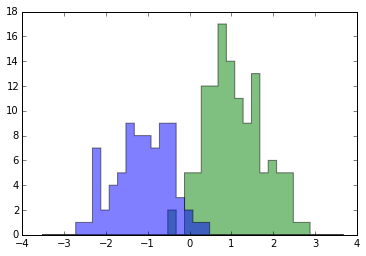

In [6]:
state, ground_truth_c = initial_state()
bins = np.arange(min(state['data'])-1, max(state['data'])+1, .2)
_ = plt.hist(group_data(state['data'], ground_truth_c).values(), 
             bins=bins, 
             histtype='stepfilled', alpha=.5)

print "initial suffstats", state["suffstats"]
print "actual suffstats", {cluster: generate_suffstat(X) for cluster, X in group_data(state['data'], ground_truth_c).iteritems()}

In [7]:
num_iterations = 500
scores = []
samples = []
suffstats = []
for i in range(num_iterations):
    state = gibbs_step(state)
#     pi, mu = sample_marginalized_parameters(state)
    suffstats.append(state['suffstats'].copy())
#     samples.append({
#         "mu_0": state["mu_0"],
#         "c": np.array(state["c"]),
#         "mu": mu,
#         "pi": pi
#     })
#     scores.append(state_score(state))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10addfe90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x10bca1790>]], dtype=object)

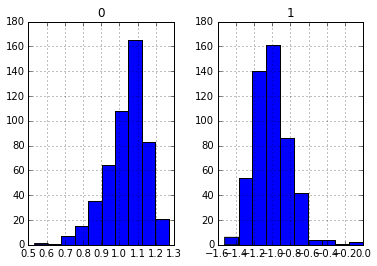

In [8]:
pd.DataFrame(np.array([[ss.mu for ss in r.values()] for r in suffstats])).hist()

### Model Score

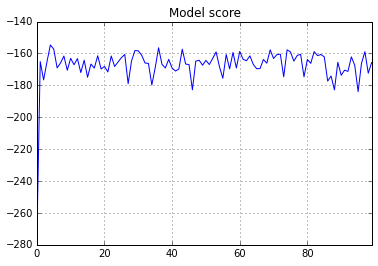

In [8]:
pd.Series(scores[:100]).plot(title="Model score")

### Cluster Means Distributions

In [9]:
mus = np.array([p["mu"] for p in samples])

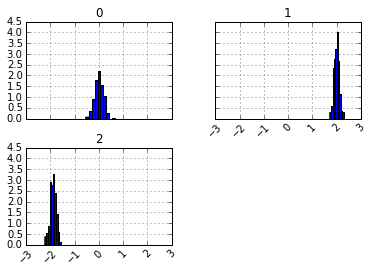

In [10]:
_ = pd.DataFrame(mus).hist(normed=True, xrot=45, sharey=True, sharex=True)

### $\mu_0$ Distribution

In [11]:
mu0 = np.array([p["mu_0"] for p in samples])

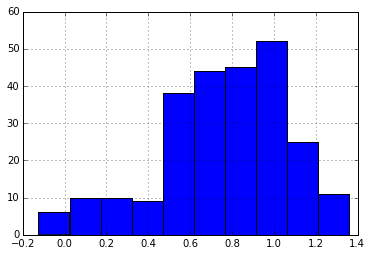

In [12]:
pd.Series(mu0).hist()

### $\pi$ Distribution

In [16]:
pd.DataFrame(pi).describe()

,0,1,2
count,250.000000,250.000000,250.000000
mean,0.214253,0.458805,0.326942
std,0.033528,0.037043,0.035381
min,0.088164,0.338972,0.224987
25%,0.193370,0.432467,0.301983
50%,0.214224,0.459338,0.324142
75%,0.236366,0.480968,0.347784
max,0.323687,0.584172,0.432516


In [15]:
pi.mean(axis=0)

array([ 0.21,  0.46,  0.33])

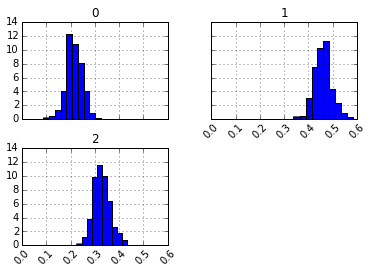

In [13]:
pi = np.array([p["pi"] for p in samples])
_ = pd.DataFrame(pi).hist(normed=True, xrot=45, sharey=True, sharex=True)